In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly

from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [10]:
from google.colab import files
uploaded = files.upload()

Saving dog.json to dog.json


In [11]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "dog.json" with length 82661 bytes


In [21]:
import io
data = pd.read_json(uploaded['dog.json'])
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head(20) 

Number of data points :  441 Number of features: 3


,image,price,product
0,https://myunikorn.com/media/product_images/Ped...,₹204.00,Pedigree Puppy Chicken and Milk 1.2Kg
1,https://myunikorn.com/media/product_images/Ped...,₹493.00,Pedigree Puppy Chicken and Milk 3kg
2,https://myunikorn.com/media/product_images/Ped...,"₹2,167.00",Pedigree Puppy Chicken and Milk 15kg
3,https://myunikorn.com/media/product_images/Ped...,"₹1,530.00",Pedigree Puppy Chicken and Milk 10kg
4,https://myunikorn.com/static/images/default/pr...,"₹2,550.00",Pedigree Adult Chicken and Vegetable 20kg
5,https://myunikorn.com/media/product_images/Ped...,"₹1,402.00",Pedigree Adult Chicken and Vegetable 10kg
6,https://myunikorn.com/media/product_images/Ped...,₹68.00,Pedigree Adult Chicken and Vegetable 400gms
7,https://myunikorn.com/media/product_images/Ped...,₹17.00,Pedigree Adult Chicken and Vegetable 100gms
8,https://myunikorn.com/media/product_images/Ped...,₹467.00,Pedigree Adult Chicken and Vegetable 3kg
9,https://myunikorn.com/media/product_images/Ped...,₹195.00,Pedigree Adult Chicken and Vegetable 1.2Kg


In [0]:

#Display an image
def display_img(url,ax,fig):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # product title
        
        # 2nd, plotting image 
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input product's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : product image url
    # text: title of recomonded product (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# BAG OF WORDS IMPLEMENTATION

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['product'])
title_features.get_shape()

(441, 297)

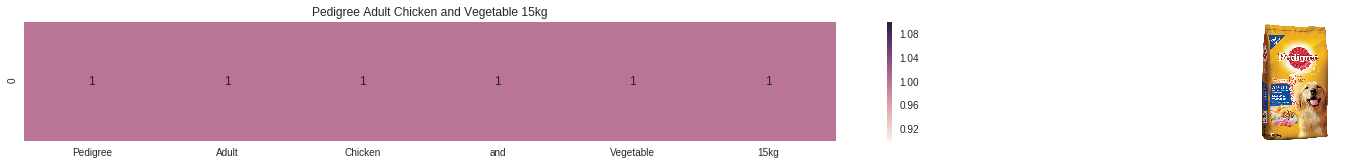

Title: Pedigree Adult Chicken and Vegetable 15kg
Euclidean similarity with the query image : 0.0


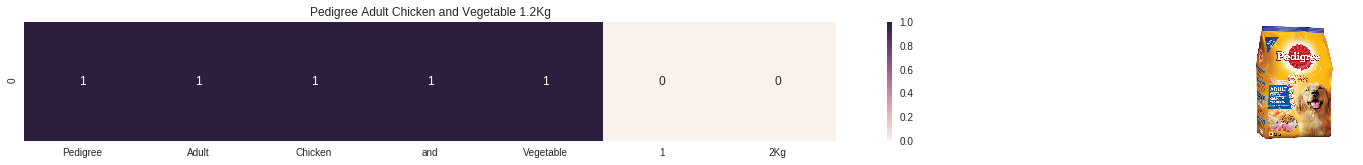

Title: Pedigree Adult Chicken and Vegetable 1.2Kg
Euclidean similarity with the query image : 1.4142135623730951


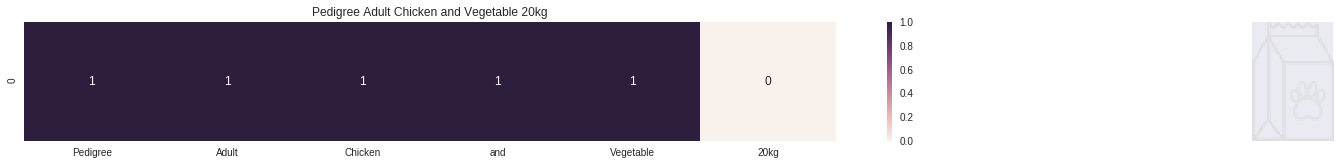

Title: Pedigree Adult Chicken and Vegetable 20kg
Euclidean similarity with the query image : 1.4142135623730951


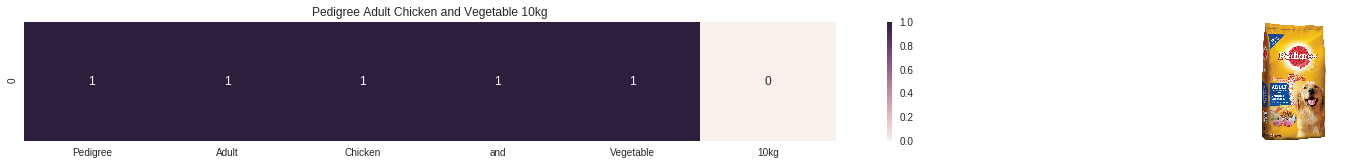

Title: Pedigree Adult Chicken and Vegetable 10kg
Euclidean similarity with the query image : 1.4142135623730951


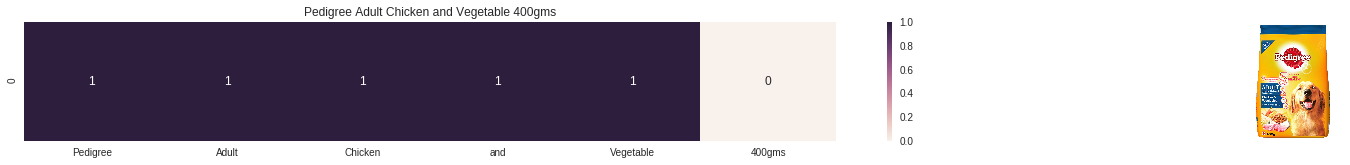

Title: Pedigree Adult Chicken and Vegetable 400gms
Euclidean similarity with the query image : 1.4142135623730951


In [16]:
def bag_of_words_model(doc_id, num_results):
    
    
    # pairwise_dist will store the distance from given input apparel to all remaining product
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['product'].loc[df_indices[0]], data['product'].loc[df_indices[i]], data['image'].loc[df_indices[i]], 'bag_of_words')
        
        print ('Title:', data['product'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(10, 5)
# 10 is the product and 5 is the number of products which we want to recommend

# TF-IDF IMPLEMENTATION

In [0]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['product'])

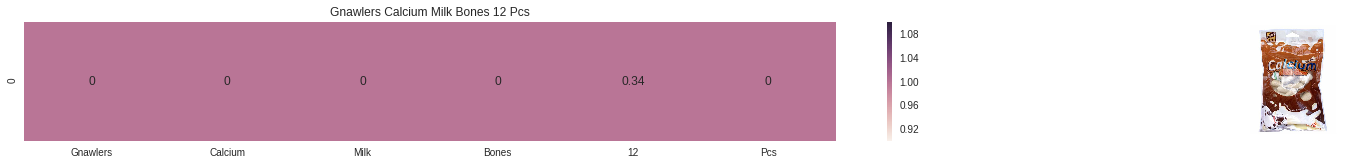

Title : Gnawlers Calcium Milk Bones 12 Pcs
Eucliden distance from the given image : 0.0


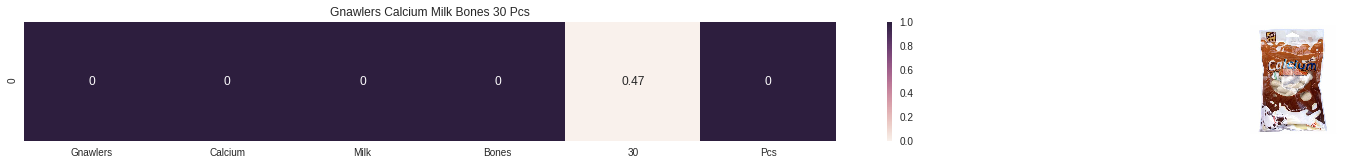

Title : Gnawlers Calcium Milk Bones 30 Pcs
Eucliden distance from the given image : 0.5833109104368934


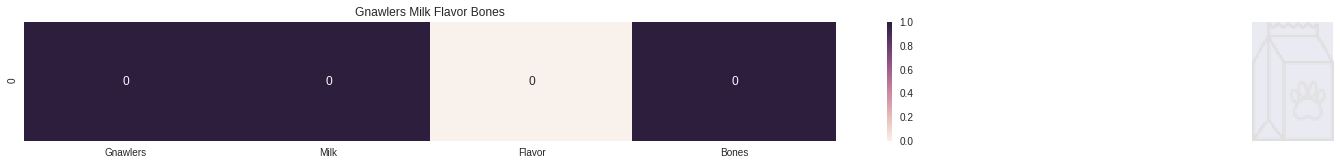

Title : Gnawlers Milk Flavor Bones
Eucliden distance from the given image : 0.9312021943235779


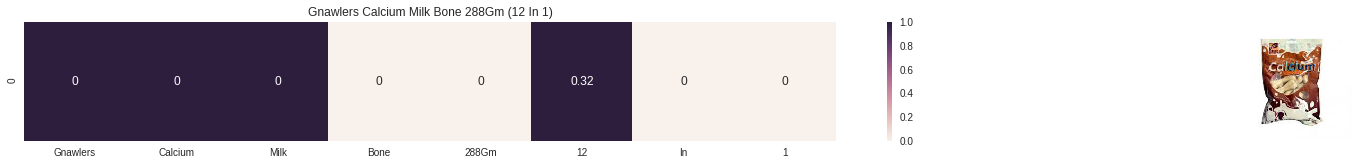

Title : Gnawlers Calcium Milk Bone 288Gm (12 In 1)
Eucliden distance from the given image : 0.9567936661854134


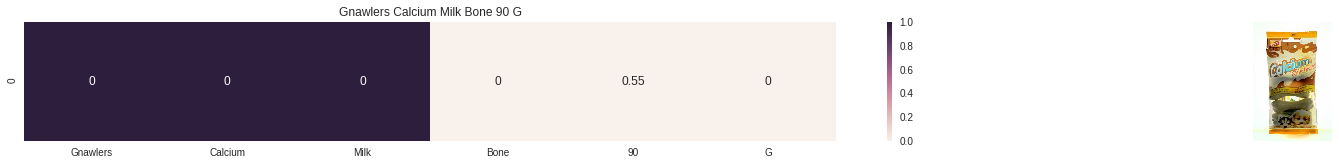

Title : Gnawlers Calcium Milk Bone 90 G
Eucliden distance from the given image : 0.9980528679609795


In [20]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input product to all remaining product
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        
        get_result(indices[i], data['product'].loc[df_indices[0]], data['product'].loc[df_indices[i]], data['image'].loc[df_indices[i]], 'tfidf')
        
        print('Title :',data['product'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(25, 5)
# 25 is the product and 5 is the number of products which we want to recommend